# Gradient Boosting model

## Import data and set up

In [19]:
# import relevant packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

%matplotlib inline

In [20]:
# set up paths
data_dir = "../data"

In [21]:
# import data 
X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(397900, 25)
(99476, 25)
(397900, 1)
(99476, 1)


In [22]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [23]:
X_train.columns

Index(['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Month', 'Year',
       'Weekday', 'Holiday', 'Customers_enc', 'StoreType_enc',
       'Assortment_enc', 'Store_enc'],
      dtype='object')

In [24]:
train_cols = ['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Month',
              'Weekday', 'Holiday', 'Customers_enc', 'StoreType_enc', 
              'Assortment_enc', 'Store_enc']

X_train = X_train[train_cols]
X_test = X_test[train_cols]
print(X_train.columns)
print(X_test.columns)

Index(['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Month', 'Weekday',
       'Holiday', 'Customers_enc', 'StoreType_enc', 'Assortment_enc',
       'Store_enc'],
      dtype='object')
Index(['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Month', 'Weekday',
       'Holiday', 'Customers_enc', 'StoreType_enc', 'Assortment_enc',
       'Store_enc'],
      dtype='object')


In [25]:
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

## Gradient Boosting

In [26]:
#xgboost
model = xgb.XGBRegressor(n_jobs=1, random_state=42)

In [27]:
# define parameter space for grid search
parameter_space = {
    'n_estimators': [500],
    'eta': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'max_depth': [7]
}

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

In [28]:
my_scorer = make_scorer(metric, greater_is_better=False)

In [29]:
%%time
regr = GridSearchCV(model, parameter_space, scoring=my_scorer, 
                   n_jobs=None, cv=5, return_train_score = True)
regr.fit(X_train, y_train)

CPU times: user 10min 25s, sys: 1.06 s, total: 10min 26s
Wall time: 10min 27s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=1,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameter

In [30]:
#Best estimator
print('Best estimator:\n', regr.best_estimator_)

# Best parameter setting
print('Best parameters found:\n', regr.best_params_)

# Scorer used on the held out data to choose best parameters for the model
print('Scorer used on the held out data to choose the best parameters for the model:', regr.scorer_)

# Mean cross-validated score of the best estimator
print('Best mean cross-validated score:', regr.best_score_)

Best estimator:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best parameters found:
 {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
Scorer used on the held out data to choose the best parameters for the model: make_scorer(metric, greater_is_better=False)
Best mean cross-validated score: -15.191864665954162


In [31]:
# All results
cv_results = pd.DataFrame.from_dict(regr.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,97.564159,1.181668,0.757797,0.010214,0.7,0.1,7,500,0.7,"{'colsample_bytree': 0.7, 'eta': 0.1, 'max_dep...",...,-15.191865,0.144461,1,-14.664859,-14.656293,-14.646372,-14.748842,-14.640758,-14.671425,0.039582


In [32]:
y_pred = regr.predict(X_test)
value = metric(y_pred, y_test)
print(value)

18.261241337548125


In [36]:
# Feature importance
model = xgb.XGBRegressor(n_estimators=1000,
                         eta=0.1,
                         subsample=0.7,
                         colsample_bytree=0.7,
                         max_depth=6,
                         n_jobs=-1, 
                         random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
value = metric(y_pred, y_test)
print(value)

print(model.feature_importances_)

18.298233244823862
[0.2625758  0.01534536 0.01337889 0.02725274 0.05179682 0.01140959
 0.04000295 0.04829056 0.02297925 0.506968  ]


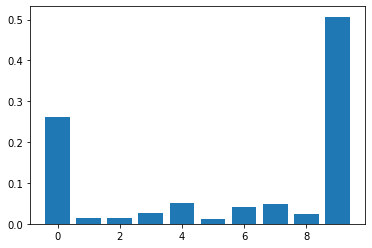

In [37]:
# plot feature importance
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [35]:
X_train.columns

Index(['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Month', 'Weekday',
       'Holiday', 'Customers_enc', 'StoreType_enc', 'Assortment_enc',
       'Store_enc'],
      dtype='object')